# Logistic Regression Consulting Project

## Binary Customer Churn

A marketing agency has many customers that use their service to produce ads for the client/customer websites. They've noticed that they have quite a bit of churn in clients. They basically randomly assign account managers right now, but want you to create a machine learning model that will help predict which customers will churn (stop buying their service) so that they can correctly assign the customers most at risk to churn an account manager. Luckily they have some historical data, can you help them out? Create a classification algorithm that will help classify whether or not a customer churned. Then the company can test this against incoming data for future customers to predict which customers will churn and assign them an account manager.

The data is saved as customer_churn.csv. Here are the fields and their definitions:

    Name : Name of the latest contact at Company
    Age: Customer Age
    Total_Purchase: Total Ads Purchased
    Account_Manager: Binary 0=No manager, 1= Account manager assigned
    Years: Totaly Years as a customer
    Num_sites: Number of websites that use the service.
    Onboard_date: Date that the name of the latest contact was onboarded
    Location: Client HQ Address
    Company: Name of Client Company
    
Once you've created the model and evaluated it, test out the model on some new data (you can think of this almost like a hold-out set) that your client has provided, saved under new_customers.csv. The client wants to know which customers are most likely to churn given this data (they don't have the label yet).

## Useful functions from other sections

In [0]:
# lets define some functions that will make the EDA simpler, incorperating visualisation and statistics between each of the 
# features with the target variable (crew)

# the continuous vs categorical function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import (ttest_ind, 
                         f_oneway, mannwhitneyu, kruskal)


import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from scipy.stats import pearsonr
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import mean, median, skewness, kurtosis, approx_count_distinct, format_number, sqrt
from pyspark.sql.types import StringType, DoubleType, LongType, StructType, StructField
from pyspark.sql.functions import (col, count, sum, 
                                    mean, min, max, round, cast)



def continuous_vs_categorical(data_frame, continuous_col, categorical_col, plot_kind ='bar'):
    
    if plot_kind not in ['strip', 'swarm', 'box', 'violin', 'boxen', 'point', 'bar', 'count']:
        raise ValueError("plot_kind not one of 'strip', 'swarm', 'box', 'violin', 'boxen', 'point', 'bar', 'count'")
    # Check the number of unique categories in the categorical column
    num_categories = data_frame.select(categorical_col).distinct().count()
    
    # If there are only two categories, perform t-test
    if num_categories == 2:
        # Get data for each category
        category1_data = data_frame.filter(col(categorical_col) == 1).select(continuous_col).rdd.flatMap(lambda x: x).collect()
        category2_data = data_frame.filter(col(categorical_col) == 0).select(continuous_col).rdd.flatMap(lambda x: x).collect()
        
        # Perform t-test
        t_stat, p_value = ttest_ind(category1_data, category2_data)
        print("T-test statistic is {:.2f}, with p-value of {:.2f}".format(t_stat, p_value))
        
        # Create bar chart with error bars using Seaborn
        data = data_frame.select(categorical_col, continuous_col).toPandas()
        sns.catplot(x=categorical_col, y=continuous_col,
                    data=data, 
                    kind=plot_kind)
        plt.title("{} by {}".format(continuous_col, categorical_col))
        plt.show()
    
    # If there are more than two categories, perform ANOVA test
    elif num_categories > 2:
        # Get data for each category
        data_by_category = data_frame.groupBy(categorical_col).agg({continuous_col: 'collect_list'}).collect()
        category_data = [x[1] for x in data_by_category]
        
        # Perform ANOVA test
        f_stat, p_value = f_oneway(*category_data)
        print("ANOVA F-statistic is {:.2f}, with p-value of {:.2f}".format(f_stat, p_value))
        
        # Create bar chart with error bars using Seaborn
        data = data_frame.select(categorical_col, continuous_col).toPandas()

        sns.catplot(x=continuous_col, y=categorical_col,
                    data=data, 
                    kind=plot_kind)
        
        plt.title("{} by {}".format(continuous_col, categorical_col))
        plt.show()
        
    # If there are no categories, print error message
    else:
        print("Error: no categories found in categorical column")
        
        
        
        

        
        
        
        
        

# continuous vs continuous
def continuous_vs_continuous(data_frame, col1, col2):
    
    # Assemble the two columns into a vector
    assembler = VectorAssembler(inputCols=[col1, col2], outputCol="features")
    assembled_data = assembler.transform(data_frame)
    
    # Calculate the correlation coefficient and p-value
    data = assembled_data.select(col1, col2).toPandas()
    corr_coeff, p_value = pearsonr(data[col1], data[col2])
    print("Correlation coefficient between {} and {} is {:.2f} with p-value {:.2f}".format(col1, col2, corr_coeff, p_value))
    
    # Create scatter plot with regression line
    plt.figure(figsize=(10, 6))
    sns.regplot(data=data, x=col1, y=col2, line_kws={"color": "red"})
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title("{} vs. {}".format(col1, col2))
    plt.show()





from scipy.stats import contingency

    
# discrete variables

def discrete_comparison(df, col1, col2):
    """
    This function performs a comparison between two discrete variables in a DataFrame.
    It performs a chi-squared test and Cramer's V statistic to measure the strength of association
    between the two variables, and also plots a heat map to visualize the contingency table.
    :param df: DataFrame containing the data
    :param col1: Name of the first discrete column to compare
    :param col2: Name of the second discrete column to compare
    :return: None
    """
    # convert to pandas
    df = df.toPandas()
    
    # Create a contingency table of the two columns
    contingency_table = pd.crosstab(df[col1], df[col2])
    
    # Calculate chi-squared test statistic, p-value, degrees of freedom
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    
    # Calculate Cramer's V statistic
    num_obs = np.sum(contingency_table.values)
    cramers_v = association(contingency_table.values)

    # Print results
    print(f"Chi-squared test statistic: {chi2:.2f}")
    print(f"P-value: {p:.2f}")
    print(f"Degrees of freedom: {dof}")
    print(f"Cramer's V statistic: {cramers_v:.2f}")
    
    # Plot a heat map of the contingency table
    plt.figure()
    sns.heatmap(contingency_table, annot=True, cmap="Blues")
    plt.title("{} vs. {}".format(col1, col2))
    plt.show()
    
    


def detect_datatype_and_plot(df, figsize=(10, 8)):
    # Loop through each column in the dataframe
    for column in df.columns:
        # Check if the column is binary
        if set(df.select(column).distinct().rdd.flatMap(lambda x: x).collect()) == {0, 1}:
            print(f"{column} is binary.")
            # Plot a bar plot with counts of 0's and 1's
            plt.figure(figsize=figsize)
            sns.countplot(data=df.toPandas(), x=column)
            plt.show()
        # Check if the column is categorical (integer)
        elif df.select(column).dtypes[0][1] == "int" and df.select(column).distinct().count() < 50:
            print(f"{column} is categorical.")
            # Plot a bar plot with counts of each category
            plt.figure(figsize=figsize)
            sns.countplot(data=df.toPandas(), x=column, order=df.toPandas()[column].value_counts().index)
            plt.show()
        # Check if the column is categorical (string)
        elif df.select(column).dtypes[0][1] == "string" and df.select(column).distinct().count() < 50:
            print(f"{column} is categorical.")
            # Plot a bar plot with counts of each category
            plt.figure(figsize=figsize)
            sns.countplot(data=df.toPandas(), x=column, order=df.toPandas()[column].value_counts().index)
            plt.show()
        # If it's numeric, plot a KDE/histogram
        elif df.select(column).dtypes[0][1] in ['int', 'bigint', 'float', 'double']:
            print(f"{column} is continuous.")
            plt.figure(figsize=figsize)
            sns.histplot(data=df.toPandas(), x=column, kde=True)
            plt.show()
        else:
            print(f"{column} is neither binary, categorical, nor continuous.")




            
# variance inflation factor between the varibles
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_calculate(data):
    data = data.toPandas()
    
    vif = pd.DataFrame()
    
    vif["VIF Factor"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    vif["features"] = data.columns
    
    return vif







from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression

def make_pipe(categorical_cols, numerical_cols, model_type='Logistic Regression', label = 'label'):
    # Define pipeline stages
    indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="skip") for col in categorical_cols]
    
    encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in categorical_cols]
    
    # VectorAssembler to assemble numerical columns into a single vector
    num_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
    
    # StandardScaler to scale the numerical features vector
    scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features", withStd=True, withMean=True)
    
    # VectorAssembler to combine encoded categorical features and scaled numerical features
    features_assembler = VectorAssembler(
        inputCols=[encoder.getOutputCol() for encoder in encoders] + [scaler.getOutputCol()], 
        outputCol="features"
    )

    if model_type == 'Logistic Regression':
        algo = LogisticRegression(featuresCol="features", labelCol=label)

    # Define the pipeline
    pipeline = Pipeline(stages=indexers + encoders + [num_assembler, scaler, features_assembler, algo])
    return pipeline







from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(model, test_data):
    # Make predictions on the test data
    predictions = model.transform(test_data).select(col("prediction"), col("Churn"))
    
    # Evaluate the model's performance using the BinaryClassificationEvaluator
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="Churn")
    auc_score = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    print("AUC score: {:.3f}".format(auc_score))
    
    # Calculate precision and recall scores
    y_true = predictions.select(['Churn']).collect()
    y_scores = predictions.select(['prediction']).collect()
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    # Plot the precision-recall curve
    plt.plot(recall, precision, color='navy', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Precision-Recall Curve')
    plt.show()
    
    # Print precision and recall scores
    print("Precision score: {:.3f}".format(precision.mean()))
    print("Recall score: {:.3f}".format(recall.mean()))
    
    
    
# functinon for null value checks:
def check_null(data):
    
    null_counts = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])
    
    return null_counts



# handy function for later when we add csv files as tables
def create_spark(table_name):
    
    data = sqlContext.sql(f"select * from {table_name}")
    data = spark.createDataFrame(data.rdd)
    
    return data




# function for extracting the location state and address

import re

def extract_state(address):
    state_pattern = r'\b[A-Za-z]{2}(?=\s|\Z)'
    state_match = re.search(state_pattern, address)
    if state_match:
        return state_match.group()
    else:
        return None
    
    
def extract_postcode(address):
    postcode_pattern = r'\b\d{5}(?:-\d{4})?\b'
    postcode_match = re.search(postcode_pattern, address)
    if postcode_match:
        return postcode_match.group()
    else:
        return None
    
    
    
    
    
    


def descriptive_stats(df):
    """
    Takes a PySpark dataframe and returns a summary of descriptive statistics for each column.
    For continuous variables, it returns the mean, median, mode, count, skewness, and kurtosis.
    For binary, nominal, or ordinal variables, it returns only the unique count.
    """
    schema = StructType([
        StructField("Column", StringType(), True),
        StructField("Mean", DoubleType(), True),
        StructField("Median", DoubleType(), True),
        StructField("Mode", StringType(), True),
        StructField("Count", LongType(), True),
        StructField("Skewness", DoubleType(), True),
        StructField("Kurtosis", DoubleType(), True),
        StructField("Unique_Count", LongType(), True)
    ])
    
    rows = []
    for c in df.columns:
        if df.select(c).dtypes[0][1] in ['double', 'float', 'int', 'bigint']:
            # calculate mean, median, mode, count, skewness, and kurtosis for continuous variables
            mean_val = df.select(mean(c)).collect()[0][0]
            median_val = df.select(median(c)).collect()[0][0]
            mode_val = df.groupBy(c).count().orderBy('count', ascending=False).collect()[0][0]
            count_val = df.select(c).count()
            skew_val = df.select(skewness(c)).collect()[0][0]
            kurtosis_val = df.select(kurtosis(c)).collect()[0][0]
            rows.append((c, round(mean_val,2), median_val, mode_val, count_val, round(skew_val,2), round(kurtosis_val,2), None))
        else:
            # calculate unique count for binary, nominal, or ordinal variables
            unique_count = df.select(approx_count_distinct(c)).collect()[0][0]
            rows.append((c, None, None, None, None, None, None, unique_count))
    
    return spark.createDataFrame(rows, schema)

## Begin Analysis

In [0]:
# create dataframe
data = create_spark('customer_churn')
data.show()
for row in data.head(5):
    
    print(row.asDict(), '\n\n')

+-------------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|              Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+-------------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|   Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|
|      Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|
|        Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|
|      Phillip White|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|13120 Daniel Moun...|           Smith Inc|    1|
|     

In [0]:
# initial stats

# from pyspark.sql.functions import (col, count, sum, 
#                                    mean, min, max, round, format_number, cast)

# data.describe().select(

#     'summary',
#     'Names',
#     format_number(col('Age').cast('int'), 2).alias('Age'),
#     format_number(col('Total_purchase').cast('float'), 2).alias('purchases'),
#     format_number(col('Num_Sites').cast('float'), 2).alias('sites'),
#     'Location',
#     'Company',
#     format_number(col('Churn').cast('float'), 2).alias('Churn')


# ).show()


descriptive_stats(data).toPandas()

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<command-3390930313817978> in <cell line: 21>()
     19 
     20 
---> 21 descriptive_stats(data).toPandas()

<command-3813503771524087> in descriptive_stats(df)
    351             skew_val = df.select(skewness(c)).collect()[0][0]
    352             kurtosis_val = df.select(kurtosis(c)).collect()[0][0]
--> 353             rows.append((c, round(mean_val,2), median_val, mode_val, count_val, round(skew_val,2), round(kurtosis_val,2), None))
    354         else:
    355             # calculate unique count for binary, nominal, or ordinal variables

/databricks/spark/python/pyspark/sql/functions.py in round(col, scale)
   1584     [Row(r=3.0)]
   1585     """
-> 1586     return _invoke_function("round", _to_java_column(col), scale)
   1587 
   1588 

/databricks/spark/python/pyspark/sql/column.py in _to_java_column(col)
     64         jco

In [0]:
check_null(data).show()

+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+
|Names|Age|Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date|Location|Company|Churn|
+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+
|    0|  0|             0|              0|    0|        0|           0|       0|      0|    0|
+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+



Age is continuous.


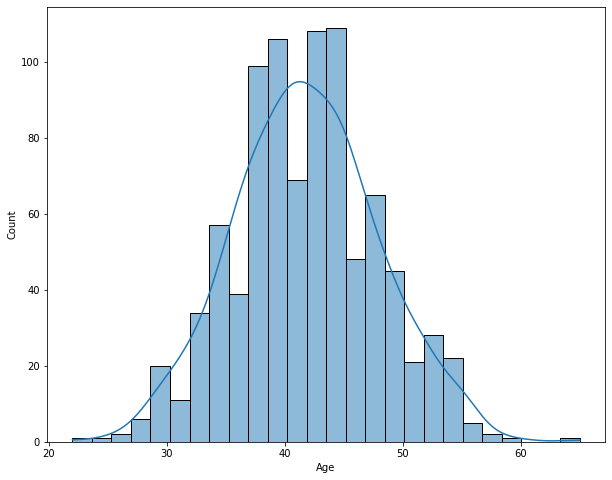

Total_Purchase is continuous.


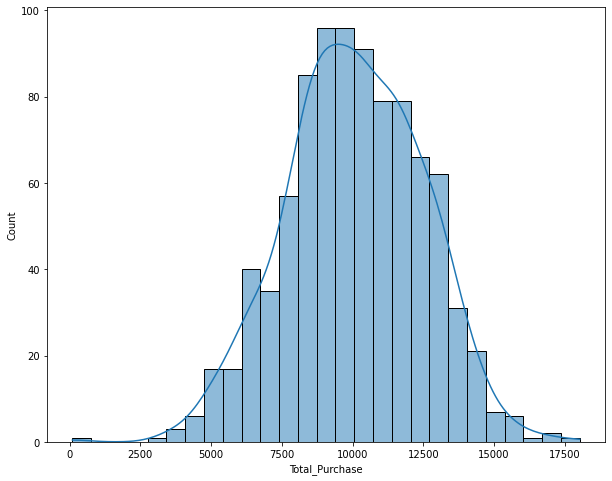

Account_Manager is binary.


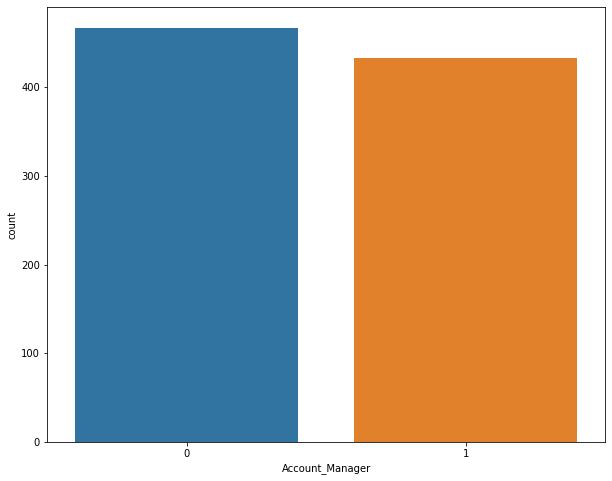

Years is continuous.


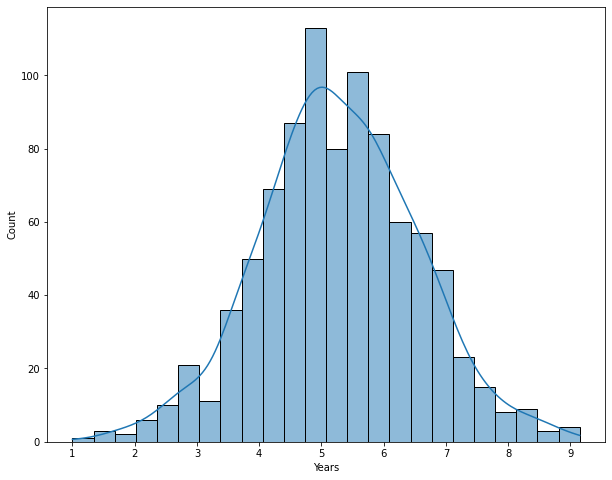

Num_Sites is continuous.


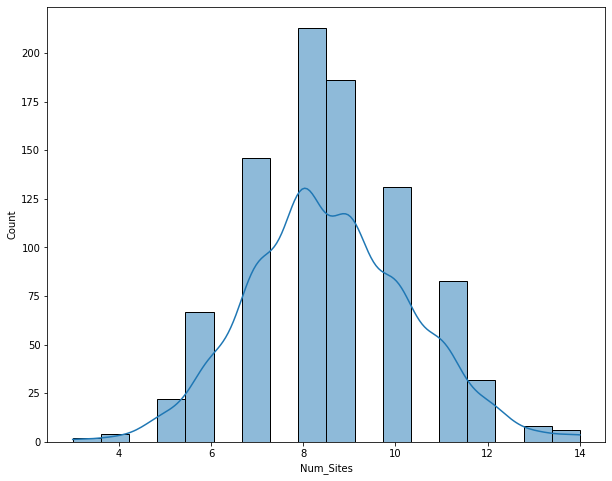

Churn is binary.


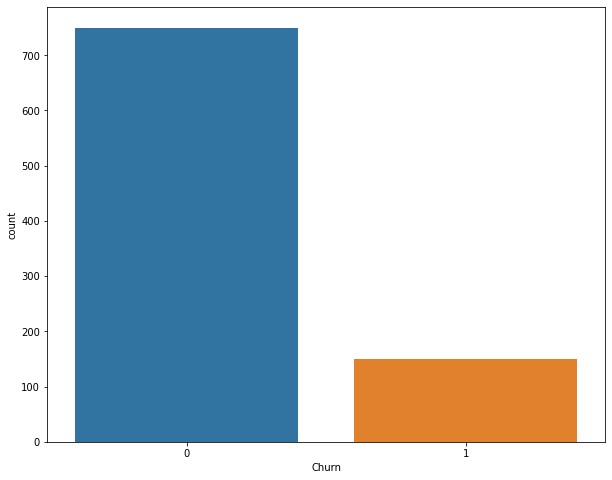

In [0]:
detect_datatype_and_plot(data.select(
    [x for x in data.columns if x not in ['Names', 'Company', 'Location', 'Onboard_date']]
))

In [0]:
# there are other features we can extract from the dataset

# initial imports
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, StringType


# create a UDF from the custom function
pyspark_state_func = udf(extract_state, StringType())

# apply the UDF to the location
data = data.withColumn('state', pyspark_state_func(col('Location')))

# display
data.select('Location', 'state').show()



+--------------------+-----+
|            Location|state|
+--------------------+-----+
|10265 Elizabeth M...|   AK|
|6157 Frank Garden...|   RI|
|1331 Keith Court ...|   DE|
|13120 Daniel Moun...|   WY|
|765 Tricia Row Ka...|   MH|
|6187 Olson Mounta...|   PR|
|4846 Savannah Roa...|   IA|
|25271 Roy Express...|   FM|
|3725 Caroline Str...|   MA|
|363 Sandra Lodge ...|   WI|
|Unit 8120 Box 916...|   AA|
|Unit 1895 Box 094...|   AA|
|897 Kelley Overpa...|   AZ|
|11488 Weaver Cape...|   WI|
|1774 Peter Row Ap...|   MT|
|45408 David Path ...|   HI|
|28216 Wright Moun...|   DE|
|Unit 4948 Box 481...|   AP|
|69203 Crosby Divi...|   CO|
|9569 Caldwell Cre...|   RI|
+--------------------+-----+
only showing top 20 rows



In [0]:
from pyspark.sql.functions import month, dayofmonth, dayofweek, year, asc, desc

# assuming your date column is named 'date_col'
data = data.withColumn('month', month('Onboard_date'))
data = data.withColumn('day', dayofmonth('Onboard_date'))
data = data.withColumn('day_of_week', dayofweek('Onboard_date'))
data = data.withColumn('year', year('Onboard_date'))

In [0]:
data.columns

Out[8]: ['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company',
 'Churn',
 'state',
 'month',
 'day',
 'day_of_week',
 'year']

In [0]:
# categorise columns into continuous, categorical

cat_features = ['Account_Manager',
 'state',
 'month',
 'day',
 'day_of_week']

cont_features = [
 'Years',
 'Num_Sites', 'Age', 'Total_Purchase']

target = 'Churn'

T-test statistic is 6.58, with p-value of 0.00


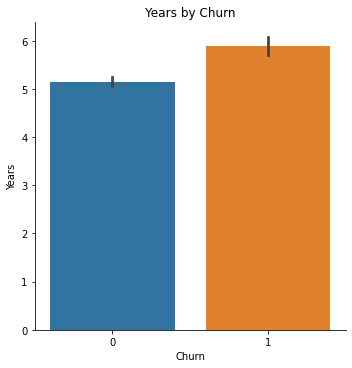

T-test statistic is 18.50, with p-value of 0.00


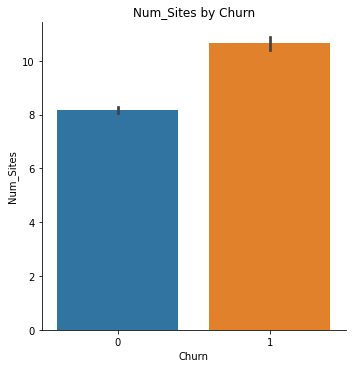

T-test statistic is 2.58, with p-value of 0.01


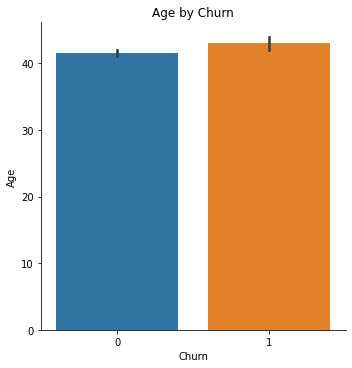

T-test statistic is 0.72, with p-value of 0.47


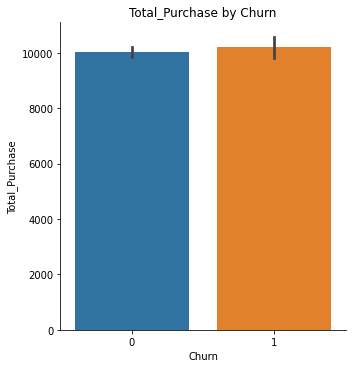

In [0]:
# becuase all of our features appear normally distributed its safe to use the ttests and anova test
for continuous in cont_features:
    
    continuous_vs_categorical(data , continuous_col = continuous, categorical_col = target)
    

Chi-squared test statistic: 4.12
P-value: 0.04
Degrees of freedom: 1
Cramer's V statistic: 0.07


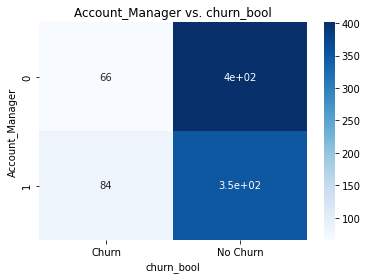

T-test statistic is 2.12, with p-value of 0.03


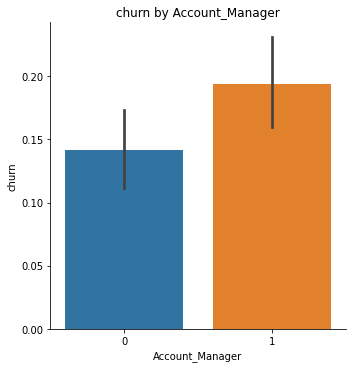



Chi-squared test statistic: 56.91
P-value: 0.62
Degrees of freedom: 61
Cramer's V statistic: 0.25


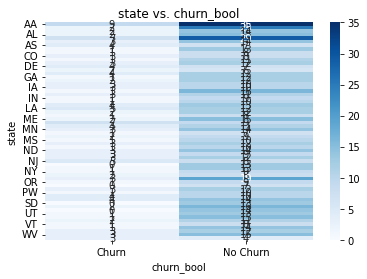

ANOVA F-statistic is 0.93, with p-value of 0.63


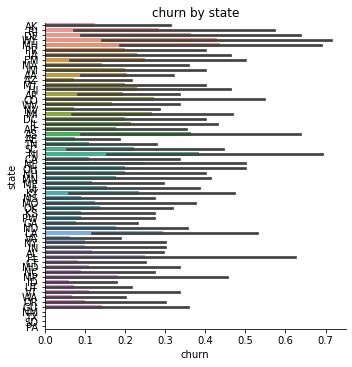



Chi-squared test statistic: 13.61
P-value: 0.26
Degrees of freedom: 11
Cramer's V statistic: 0.12


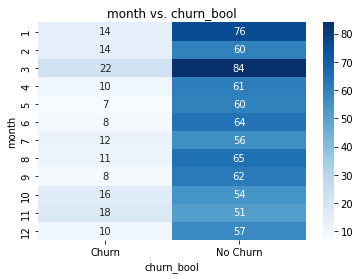

ANOVA F-statistic is 1.24, with p-value of 0.26


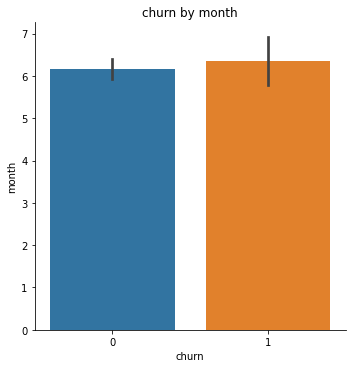



Chi-squared test statistic: 31.03
P-value: 0.41
Degrees of freedom: 30
Cramer's V statistic: 0.19


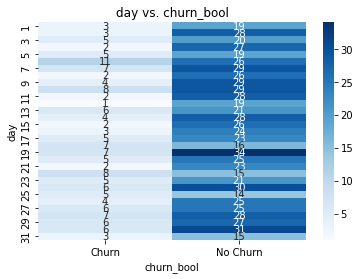

ANOVA F-statistic is 1.03, with p-value of 0.42


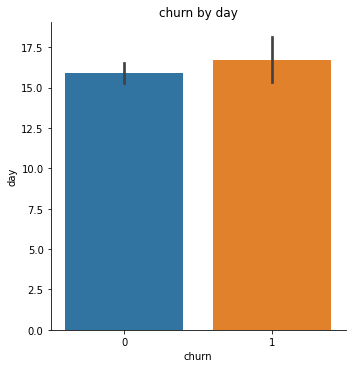



Chi-squared test statistic: 5.38
P-value: 0.50
Degrees of freedom: 6
Cramer's V statistic: 0.08


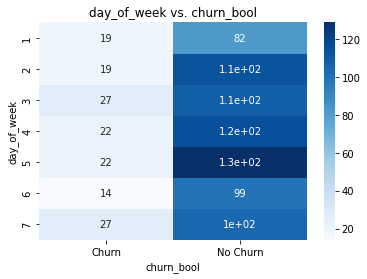

ANOVA F-statistic is 0.89, with p-value of 0.50


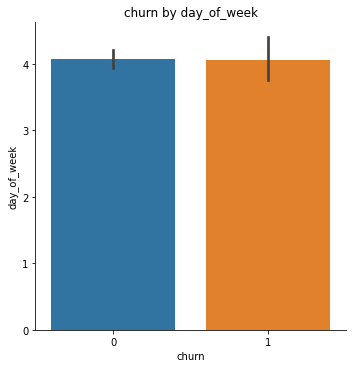

In [0]:

def churn_value_change(value):
    if value == 1:
        return 'Churn'
    else:
        return 'No Churn'
    
churn_func = udf(churn_value_change , StringType())

temp_data = data.withColumn('churn_bool', churn_func(col('Churn'))) 

for cat in cat_features:
    
    discrete_comparison(temp_data , col1 = cat, col2 = 'churn_bool')
    continuous_vs_categorical(temp_data, continuous_col = 'churn' , categorical_col=cat)
    print('\n')


will only keep account manager since the p is significant, important to note the accociation is considered extremely weak!

In [0]:


# how does churn look over time?

agg_df = data.groupby('year').agg(
        mean('Churn').alias('mean_col'),
        count('Churn').alias('count_col')
    )
agg_df = agg_df.withColumn('se_col', sqrt(col('mean_col')*(1-col('mean_col')) / col('count_col')))
agg_df = agg_df.select(col('year'), col('mean_col'), col('se_col'), col('count_col')).sort(asc('year'))

# Convert to Pandas DataFrame
pandas_df = agg_df.toPandas()

pandas_df

,year,mean_col,se_col,count_col
0,2006,0.186275,0.038549,102
1,2007,0.188889,0.041259,90
2,2008,0.223684,0.047800,76
3,2009,0.107143,0.033747,84
4,2010,0.190476,0.042845,84
5,2011,0.208333,0.047861,72
6,2012,0.164179,0.045256,67
7,2013,0.125000,0.036975,80
8,2014,0.106796,0.030432,103
9,2015,0.186667,0.044992,75


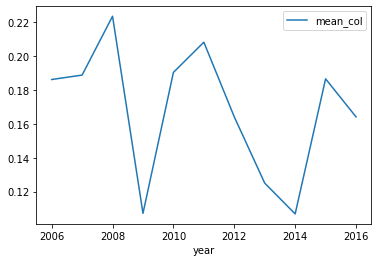

In [0]:
pandas_df.plot('year', 'mean_col');



relationship between years and churn means that the training data should be split by the years, this way we can account for polynomial relatioship.

In [0]:
cat_features

Out[14]: ['Account_Manager', 'state', 'month', 'day', 'day_of_week']

In [0]:
cont_features

Out[15]: ['Years', 'Num_Sites', 'Age', 'Total_Purchase']

In [0]:
model_cont = ['Years', 'Num_Sites', 'Age']
model_cat = ['state']

pipe = make_pipe(model_cat , model_cont)

In [0]:
pipe = make_pipe(model_cat , model_cont, label = 'Churn')

In [0]:
train_data , test_data = data.randomSplit([0.8,0.2])

lr_model = pipe.fit(train_data)

In [0]:
results = lr_model.transform(test_data)
results.summary

Out[73]: <bound method DataFrame.summary of DataFrame[Names: string, Age: double, Total_Purchase: double, Account_Manager: bigint, Years: double, Num_Sites: double, Onboard_date: timestamp, Location: string, Company: string, Churn: bigint, state: string, month: int, day: int, day_of_week: int, year: int, state_index: double, state_encoded: vector, numerical_features: vector, scaled_numerical_features: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]>

AUC score: 0.667


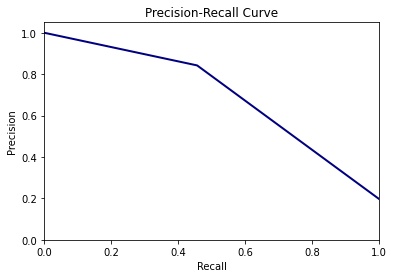

Precision score: 0.680
Recall score: 0.486


In [0]:
plot_precision_recall_curve(lr_model, test_data)

In [0]:
data.columns

Out[49]: ['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company',
 'Churn',
 'state',
 'month',
 'day',
 'day_of_week',
 'year']

In [0]:
base = 1 - list(data.select(mean('Churn')).collect()[0].asDict().values())[0]
base

Out[59]: 0.8333333333333334

In [0]:
new_records = create_spark('new_customers')
new_records.columns
new_records = new_records.withColumn('month', month('Onboard_date'))
predictions = lr_model.transform(new_records)

In [0]:
predictions.toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field month_encoded. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,month,month_index,month_encoded,numerical_features,scaled_numerical_features,features,rawPrediction,probability,prediction
0,Andrew Mccall,37.0,9935.53,1,7.71,8.0,2011-08-29 18:37:54,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd,8,6.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[7.71, 8.0, 37.0]","[1.9058364783173483, -0.30734384029262335, -0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[3.426980116065031, -3.426980116065031]","[0.9685371731722722, 0.03146282682772783]",0.0
1,Michele Wright,23.0,7526.94,1,9.28,15.0,2013-07-22 18:19:54,"21083 Nicole Junction Suite 332, Youngport, ME...",Cannon-Benson,7,5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[9.28, 15.0, 23.0]","[3.125435800356783, 3.6470415598733616, -3.048...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[-6.909042088609796, 6.909042088609796]","[0.0009977175834203066, 0.9990022824165797]",1.0
2,Jeremy Chang,65.0,100.00,1,1.00,15.0,2006-12-11 07:48:13,"085 Austin Views Lake Julialand, WY 63726-4298",Barron-Robertson,12,10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 15.0, 65.0]","[-3.3065911974053335, 3.6470415598733616, 3.73...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.9374707596106866, 3.9374707596106866]","[0.019124585258829315, 0.9808754147411707]",1.0
3,Megan Ferguson,32.0,6487.50,0,9.40,14.0,2016-10-28 05:32:13,"922 Wright Branch North Cynthialand, NC 64721",Sexton-Golden,10,11.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.4, 14.0, 32.0]","[3.2186535829330465, 3.0821293598496493, -1.59...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.257264757947414, 6.257264757947414]","[0.0019128147999767065, 0.9980871852000233]",1.0
4,Taylor Young,32.0,13147.71,1,10.00,8.0,2012-03-20 00:36:46,Unit 0789 Box 0734 DPO AP 39702,Wood LLC,3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[10.0, 8.0, 32.0]","[3.684742495814359, -0.30734384029262335, -1.5...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5416538368128379, -0.5416538368128379]","[0.6321970583914462, 0.36780294160855376]",0.0
5,Jessica Drake,22.0,8445.26,1,3.46,14.0,2011-02-04 19:29:27,1148 Tina Stravenue Apt. 978 South Carlos TX 2...,Parks-Robbins,2,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.46, 14.0, 22.0]","[-1.395626654591951, 3.0821293598496493, -3.21...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.3504226058499817, 2.3504226058499817]","[0.0870321873388667, 0.9129678126611334]",1.0


The model produced has an auc above .5 demonstrating better performance than the baseline. Several weak models like this one can be used synchronously in a voting classifier with each other.